In [34]:
import numpy as np
import numpy.fft as fft
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import networkx as nx
import scipy.stats as stats
from itertools import product

In [127]:
def structure_factor(interface_dict, min_t=0):
    factors = []
    q = fft.fftfreq(len(interface_dict[0]))
    mask =  q>=0
    for t in interface_dict:
        if(t >= min_t):
            s_q = fft.ifft(np.abs(fft.fft(interface_dict[t]))**2).real
            factors.append(s_q)
    
    return q,factors

In [128]:
freq,factors = structure_factor(interface_dict, 40000)

In [136]:
plt.scatter(freq,factors[-1])
plt.xscale('log')
plt.yscale('log')

In [8]:
def bin_group(x,y,x_bins, right=False):
    n_bins = 0
    if(type(x_bins) is int):
        n_bins = x_bins
        binning = np.linspace(np.min(x), np.max(x), n_bins)
    else:
        n_bins = len(x_bins)
        binning = x_bins
    x_classes = np.digitize(x,binning, right=right)
    classes_idx = [ np.argwhere(x_classes==c) for c in range(1,n_bins+1)]
    y_groups = [y[classes_idx[c].flatten()]  for c in range(0,n_bins)]
    return binning, y_groups
def mean_bin_group(x,y,x_bins,right=False):
    x_binned,y_groups = bin_group(x,y,x_bins, right)
    y_binned= np.array([np.mean(y_b) if len(y_b)>0 else 0 for y_b in y_groups ])
    mask = y_binned > 0
    return x_binned[mask], y_binned[mask]

In [9]:
def center(z):
    mask1 = (z==-1).sum(axis=0)
    mask2 = (z==-1).sum(axis=1)
    max1 = mask1.max()
    max2 = mask2.max()
    boundary1 = np.argwhere(mask1 == max1).flatten()
    boundary2 = np.argwhere(mask2==max2).flatten()
    lb1 = np.argmax(np.diff(boundary1))
    lb2 = np.argmax(np.diff(boundary2))
    minb_1, maxb_1 = boundary1[lb1],boundary1[lb1+1] #lateral figure
    minb_2, maxb_2 = boundary2[lb2],boundary2[lb2+1]
    xc = (minb_1+maxb_1)/2
    yc = (minb_2+maxb_2)/2
    radius_x = (maxb_1-minb_1)/2
    radius_y = (maxb_2-minb_2)/2
    return xc,yc,radius_x,radius_y

In [10]:
def bin_log(data, bins=50):
    if(type(bins) is int):
        binning = np.logspace(0,np.log10(np.max(data)), bins)
    else:
        binning = bins
    hist, edges = np.histogram(data,bins=binning, density=True)
    mask = hist > 0
    hist = hist[mask]
    edges = ((edges[0:-1]+edges[1:])*0.5)[mask]
    return hist, edges, binning

In [11]:
filename='interface0.13.pkl'
with open(filename, 'rb') as f:
    interface_dict, x_dict, y_dict, t_dict = pickle.load(f)

In [12]:
def build_network(xs,ys,times,time_cut,tol=2):
    network = {}
    for idx, (t,x,y) in enumerate(zip(times,xs,ys)):
        network[t] = []
        for (s,u,v) in zip(times[idx+1:],xs[idx+1:],ys[idx+1:]):
            if((s-t)>time_cut):
                break
            if(np.min(np.abs(x.reshape(-1,1)-u.reshape(1,-1))+np.abs(y.reshape(-1,1)-v.reshape(1,-1))) <=tol):
                network[t].append(s)
    return network

In [13]:
def get_avalanches(x_dict, y_dict, clusters):
    S = []
    for c in clusters:
        x_uq = []
        y_uq = []
        for idx in c:
            x_uq.append(x_dict[idx])
            y_uq.append(y_dict[idx])
        z = np.vstack((np.concatenate(x_uq),np.concatenate(y_uq))).T
        z = np.unique(z,axis=0)
        S.append(z.shape[0])
    return np.array(S)

In [14]:
def summary_stat(interface_dict, x_dict,y_dict,clusters):
    jumps = []
    lateral1 = []
    lateral2 = []
    n_angles = []
    for c in clusters:
        temp = 0
        uq_sites = set()
        for idx in c:
            if(idx > 0):
                delta = interface_dict[idx]-interface_dict[idx-1]
                uq_sites.update(list(np.nonzero(delta>0)[0]))
                temp += np.sum(delta)
            else:
                temp += np.sum(interface_dict[0])
                uq_sites.update(list(np.nonzero(interface_dict[0])[0]))
        uq_sites = np.array(list(uq_sites),dtype=int)
        last_h = interface_dict[c[-1]]
        first_h = interface_dict[c[0]]
        lateral1.append(last_h[uq_sites].mean()*len(uq_sites))
        lateral2.append(first_h[uq_sites].mean()*len(uq_sites))
        jumps.append(temp)
        n_angles.append(len(uq_sites))
    return np.array(jumps), np.array(lateral1), np.array(lateral2), np.array(n_angles)

In [15]:
xs = [x_dict[t] for t in t_dict]
ys = [y_dict[t] for t in t_dict]
ts = list(t_dict.keys())

In [16]:
time_cuts = [16,18,20]
tols = [2]

In [17]:
net_coll = []
for tcut in time_cuts:
    print('t_cut', tcut)
    nets = []
    for tol in tols:
        print('tol', tol)
        net = build_network(xs,ys,ts,tcut,tol)
        nets.append(net)
    net_coll.append(nets)

t_cut 16
tol 2
t_cut 18
tol 2
t_cut 20
tol 2


In [18]:
cl_coll = []
for tcut, nets in zip(time_cuts, net_coll):
    clusters = []
    for tol, net in zip(tols, nets):
        g = nx.Graph()
        g.add_nodes_from(net.keys())
        for k, v in net.items():
            g.add_edges_from(([(k, t) for t in v]))
        sub_graphs = nx.connected_components(g)
        clusters.append([ np.sort(np.array(list(sg))) for sg in sub_graphs])
    cl_coll.append(clusters)

16


<ipython-input-14-a35820ed8cf7>:20: RuntimeWarning: Mean of empty slice.
  lateral1.append(last_h[uq_sites].mean()*len(uq_sites))
/home/vicio/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-a35820ed8cf7>:21: RuntimeWarning: Mean of empty slice.
  lateral2.append(first_h[uq_sites].mean()*len(uq_sites))


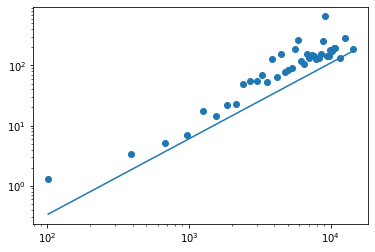

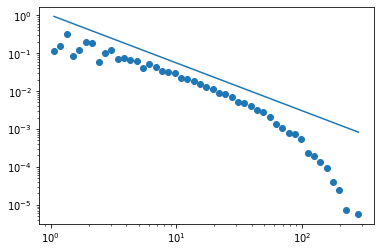

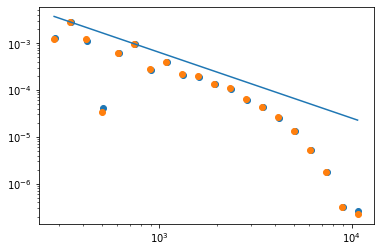

18


<ipython-input-14-a35820ed8cf7>:20: RuntimeWarning: Mean of empty slice.
  lateral1.append(last_h[uq_sites].mean()*len(uq_sites))
/home/vicio/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-a35820ed8cf7>:21: RuntimeWarning: Mean of empty slice.
  lateral2.append(first_h[uq_sites].mean()*len(uq_sites))


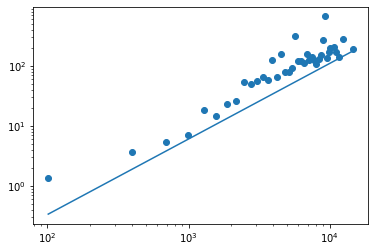

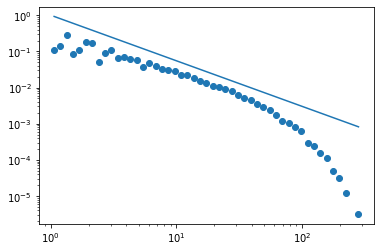

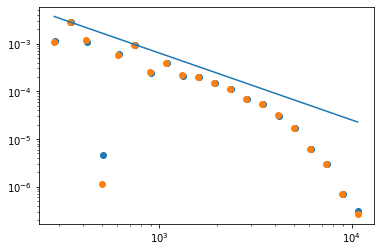

20


<ipython-input-14-a35820ed8cf7>:20: RuntimeWarning: Mean of empty slice.
  lateral1.append(last_h[uq_sites].mean()*len(uq_sites))
/home/vicio/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-a35820ed8cf7>:21: RuntimeWarning: Mean of empty slice.
  lateral2.append(first_h[uq_sites].mean()*len(uq_sites))


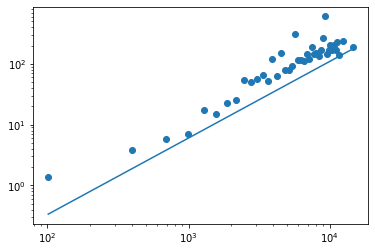

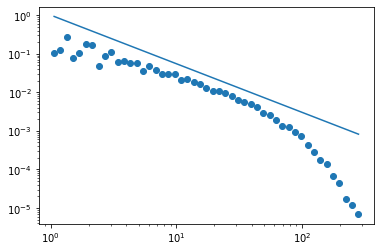

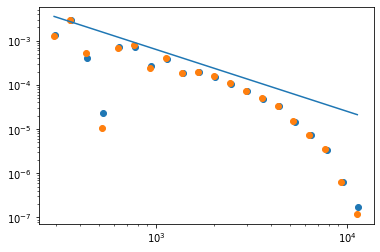

In [33]:
%matplotlib inline
for i in range(len(time_cuts)):
    for j in range(len(tols)):
        if(tols[j]==2):
            print(time_cuts[i])
            jumps,lat1,lat2, n_angles = summary_stat(interface_dict, x_dict,y_dict,cl_coll[i][j])
            mask = np.isfinite(lat1)
            x_group, y_group = mean_bin_group(lat1[mask],jumps[mask],np.logspace(np.log10(lat1[mask].min()),np.log10(lat1[mask].max())))
            plt.scatter(x_group,y_group)
            plt.plot(x_group, 0.001*x_group**1.26)
            plt.yscale('log')
            plt.xscale('log')
            plt.show()
            lat1 = lat1[np.isfinite(lat1)]
            lat2 = lat2[np.isfinite(lat2)]
            hist, edges, _ = bin_log(jumps[1000:])
            plt.scatter(edges,hist)
            plt.plot(edges,edges**(-1.26))
            plt.yscale('log')
            plt.xscale('log')
            plt.show()
            hist, edges, _ = bin_log(lat1[5000:])
            plt.scatter(edges,hist)
            hist, edges, _ = bin_log(lat2[5000:])
            plt.scatter(edges,hist)
            plt.plot(edges,10*edges**(-1.4))
            plt.yscale('log')
            plt.xscale('log')
            plt.show()
            

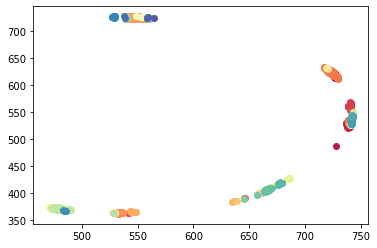

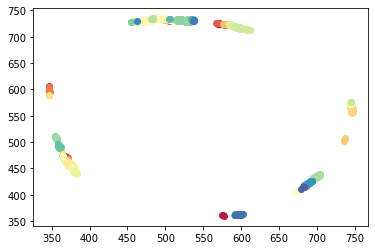

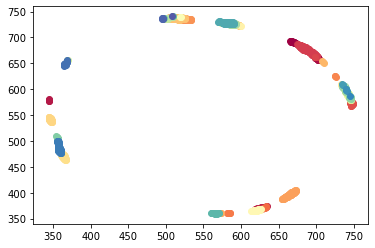

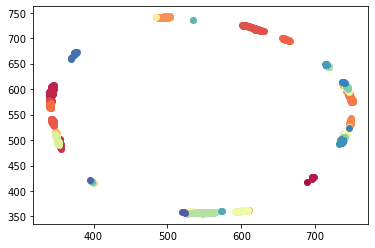

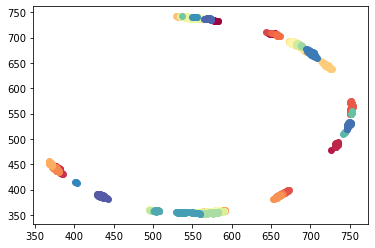

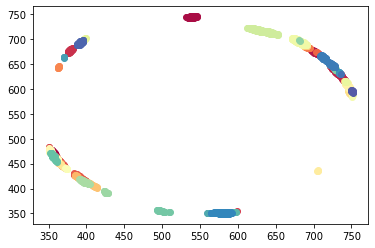

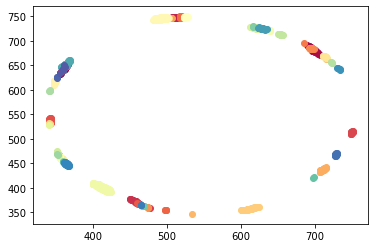

In [193]:
cmap = matplotlib.cm.get_cmap('Spectral')
%matplotlib inline
max_plots = 3050
min_plots = 3000
for j,clusters in enumerate(cl_coll[5]):
    plt.figure()
    for cidx in range(min_plots, max_plots):
        for cnt,idx in enumerate(clusters[cidx]):
            shade = (cidx-min_plots)/(max_plots-min_plots)
            if(cnt == 0):
                plt.scatter(x_dict[idx],y_dict[idx],color=cmap(shade),label='(%i,%i)'%(clusters[cidx][0],clusters[cidx][-1]))
            else:
                plt.scatter(x_dict[idx],y_dict[idx],color=cmap(shade))
    plt.show()